# Ensemble

In [1]:
#hide 
%load_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
from tqdm.auto import tqdm
from matplotlib import pyplot as plt
from IPython.display import display, Image

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from lightgbm.sklearn import LGBMRegressor

from skfin.plot import line, bar
from skfin.datasets import load_kf_returns
from skfin.mv_estimators import MeanVariance 
from skfin.backtesting import Backtester
from skfin.metrics import sharpe_ratio
from skfin.estimators import RidgeCV, MultiOutputRegressor, MLPRegressor


import logging
logging.getLogger('skfin.datasets').setLevel(logging.CRITICAL)

returns_data = load_kf_returns(cache_dir='data')
ret = returns_data['Monthly']['Average_Value_Weighted_Returns'][:'1999']

transform_X = lambda x: x.rolling(12).mean().fillna(0).values
transform_y = lambda x: x.shift(-1).values
features = transform_X(ret)
target = transform_y(ret)

## Ensemble 

Rather than choosing a single estimator (or set of parameters) among many, another stategy is to combine all the possible estimators/parameters. `scikit-learn` allows to do that with classes such as `VotingRegressor`.

In [2]:
from skfin.estimators import Ridge
from sklearn.ensemble import VotingRegressor

class VotingRegressor(VotingRegressor):
    def transform(self, X):
        return self.predict(X)

In [3]:
estimators_ = [('ridge1', Ridge(alpha=1)),  
               ('ridge2', Ridge(alpha=100)), ]

By default, `VotingRegressor` applies equal weights across regressors. 

In [4]:
estimator = make_pipeline(StandardScaler(with_mean=False), 
                          MultiOutputRegressor(VotingRegressor(estimators=estimators_)), 
                          MeanVariance())

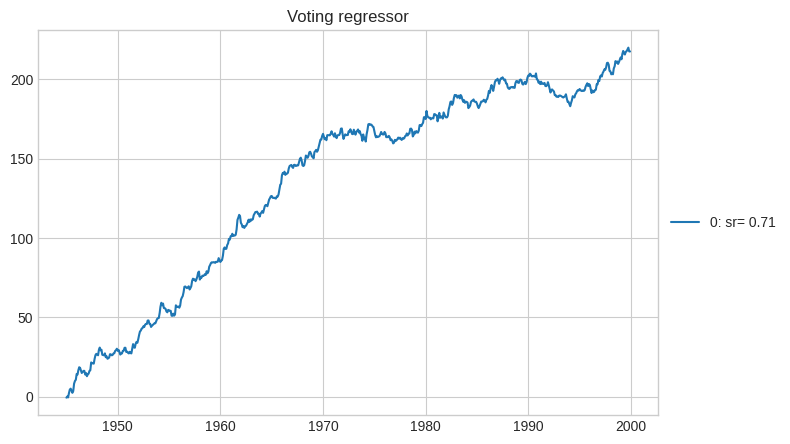

In [5]:
m = Backtester(estimator, ret).train(features, target)
line(m.pnl_, cumsum=True, title='Voting regressor')

In `scikit-learn`, there is also a `StackingRegressor` but it requires a bit more work to make it work with `MultiOutputRegressor` (and constraints on transform/regressors). 

## Rolling ensemble backtest

In this section, we build a custom ensemble method to learn weights on different estimators from pnls. 

### StackingBacktester

We consider three estimators: 
    
- the simple Industry momentum. 

- a strategy that learns cross-industry effect with `Ridge`. 

- a strategy that learns cross-industry effect with `Lightgbm`. 

In [6]:
estimators = {'momentum': MeanVariance(), 
              'ridge':  make_pipeline(StandardScaler(with_mean=False), Ridge(), MeanVariance()), 
              'lightgbm': make_pipeline(MultiOutputRegressor(LGBMRegressor(min_child_samples=5, 
                                                             n_estimators=25, n_jobs=1)), MeanVariance())
             }

In [7]:
pnls = pd.concat({k: Backtester(v, ret).train(features, target).pnl_ for k, v in estimators.items()}, axis=1)

To construct an equal-weight strategy, we scale the sum of the pnl by the square-root of the number of strategy: 
    
$$pnl_{\text{equal weight}} = \frac{\sum_{n=1}^{n=N} pnl_n}{\sqrt{N}}.$$

In this case, if the individual pnls $pnl_n$ are identically and independently distributed (with the same standard deviation), then $pnl_{\text{equal weight}}$ has the same standard deviation too.  

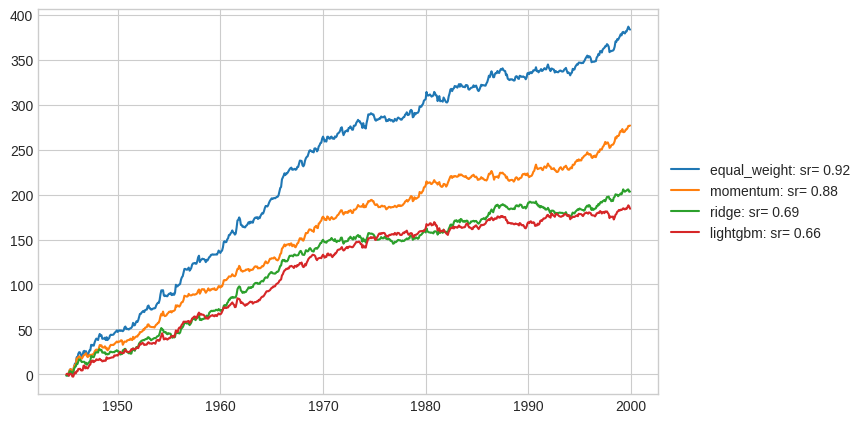

In [8]:
pnls_ = pnls.assign(equal_weight = lambda x: x.sum(axis=1).div(np.sqrt(x.shape[1])))
line(pnls_, cumsum=True)

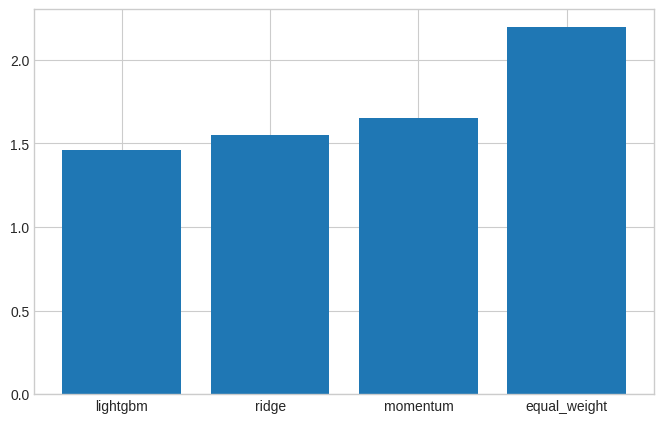

In [9]:
bar(pnls_.std())

The average correlation is not particularly high, which explains with some simple ensemble seems to help. 

In [10]:
print(f'The average pnl correlation between estimators is {pnls.corr().stack().loc[lambda x: x!=1].mean():.2f}')

The average pnl correlation between estimators is 0.50


We introduce a `StackingBacktester` with the `sklearn` api. 

In [11]:
%%writefile ../skfin/ensemble.py
import numpy as np
import pandas as pd
from dataclasses import dataclass

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.base import BaseEstimator, TransformerMixin

from skfin.mv_estimators import Mbj

@dataclass         
class StackingBacktester:
    estimators: dict
    ret: pd.DataFrame
    max_train_size: int =36
    test_size: int = 1
    start_date: str = "1945-01-01"
    end_date: str = None
    window: int =60
    min_periods: int =60
    final_estimator: TransformerMixin=Mbj()

    def __post_init__(self):
        self.ret = self.ret[: self.end_date]
        self.cv = TimeSeriesSplit(
            max_train_size=self.max_train_size,
            test_size=self.test_size,
            n_splits=1 + len(self.ret.loc[self.start_date:self.end_date]) // self.test_size,
        )


    def train(self, features, target):
        N_estimators = len(self.estimators)
        cols = self.ret.columns
        idx = self.ret.index[
            np.concatenate([test for _, test in self.cv.split(self.ret)])
        ]

        _h = {k: [] for k in list(self.estimators.keys()) + ["ensemble"]}
        _pnls = {k: [] for k in self.estimators.keys()}
        _coef = []
        for i, (train, test) in enumerate(self.cv.split(self.ret)):
            h_ = {}
            if i > self.min_periods:
                pnl_window = np.stack(
                    [np.array(v[-self.window :]) for k, v in _pnls.items()], axis=1
                )
                coef_ = self.final_estimator.fit(pnl_window).coef_
                _coef += [coef_]
            else:
                _coef += [np.zeros(N_estimators)]
            for k, m in self.estimators.items():
                m.fit(features[train], target[train])
                h_[k] = m.predict(features[test])
                _h[k] += [h_[k]]
                if i + 1 < len(idx):
                    _pnls[k] += [self.ret.loc[idx[i + 1]].dot(np.squeeze(h_[k]))]
            if i > self.min_periods:
                h_ensemble = (
                    np.stack([np.squeeze(v) for v in h_.values()], axis=1)
                    .dot(coef_)
                    .reshape(-1, 1)
                )
                V_ = m.named_steps["meanvariance"].V_
                h_ensemble = h_ensemble / np.sqrt(
                    np.diag(h_ensemble.T.dot(V_.dot(h_ensemble)))
                )
            else:
                h_ensemble = np.zeros([len(cols), 1])
            _h["ensemble"] += [h_ensemble.T]

        self.h_ = {
            k: pd.DataFrame(np.concatenate(_h[k]), index=idx, columns=cols)
            for k in _h.keys()
        }
        self.pnls_ = pd.concat(
            {
                k: v.shift(1).mul(self.ret).sum(axis=1)[self.start_date :]
                for k, v in self.h_.items()
            },
            axis=1,
        )
        self.coef_ = pd.DataFrame(
            np.stack(_coef), index=idx, columns=self.estimators.keys()
        )
        return self

Overwriting ../skfin/ensemble.py


In [12]:
from skfin.mv_estimators import Mbj

We first use the Britten-Jones (1999) trick (with the `Mbj` estimator) to compute the unconstrained mean-variance weigts over the full sample: 

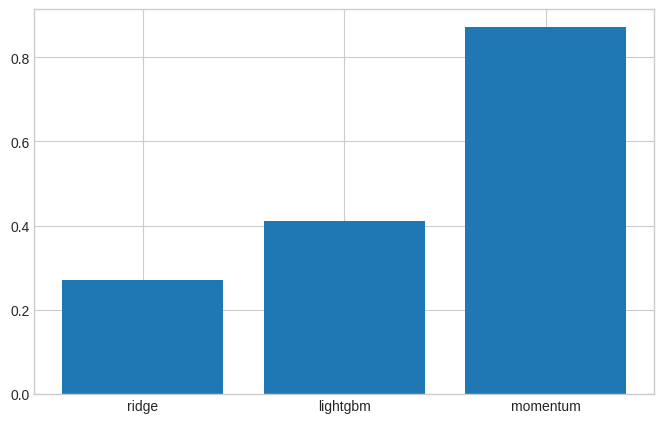

In [13]:
m = Mbj()
m.fit(pnls)
bar(pd.Series(m.coef_, index=pnls.columns))

These in-sample optimal weights improve even more the sharpe ratio -- but this is `in-sample`! 

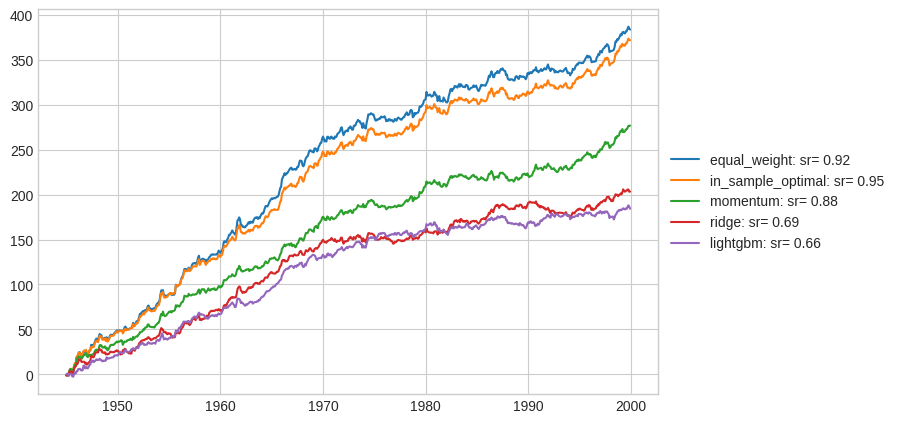

In [14]:
line(pnls_.assign(in_sample_optimal = Mbj().fit_transform(pnls)), cumsum=True)

The `StackingBacktester` computes the performance with the learned weights over rolling windows of 60 months (5 years). 

In [15]:
from skfin.ensemble import StackingBacktester

In [16]:
m = StackingBacktester(estimators=estimators, 
                       ret=ret, window=60,min_periods=60).train(features, target)
pnls = pnls.assign(ensemble_mbj= m.pnls_['ensemble'])

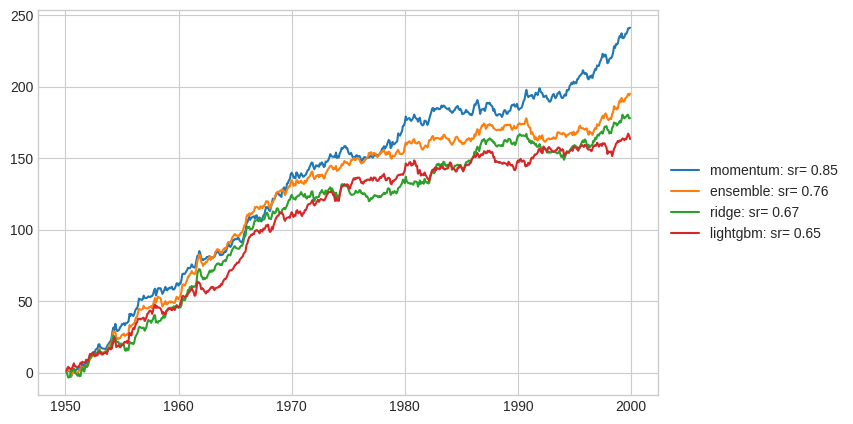

In [17]:
line(m.pnls_['1950-02-01':], cumsum=True)

To understand why the performance is lower, it is useful to look at the weights -- in this case, the weights are often negative. 

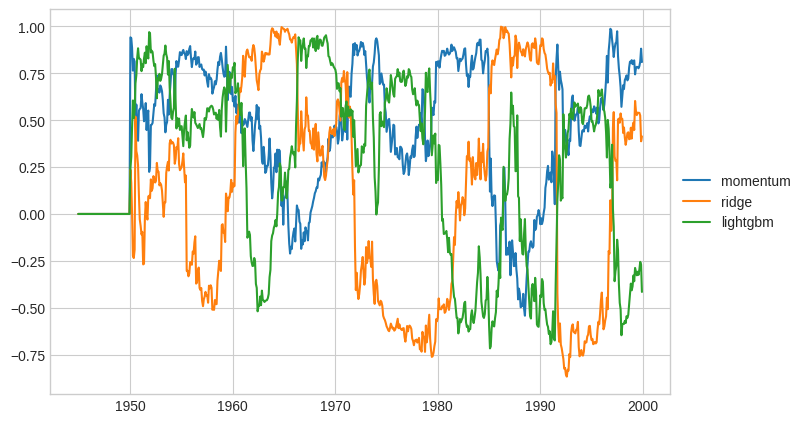

In [18]:
line(m.coef_)

We redo the exercise with a positive-weight constraint. 

In [19]:
from skfin.mv_estimators import Mbj

In [20]:
m = StackingBacktester(estimators=estimators, 
                       final_estimator=Mbj(positive=True), 
                       ret=ret, 
                       window=60,
                       min_periods=60)
m.train(features, target)
pnls['ensemble_mbj_positive'] = m.pnls_['ensemble']

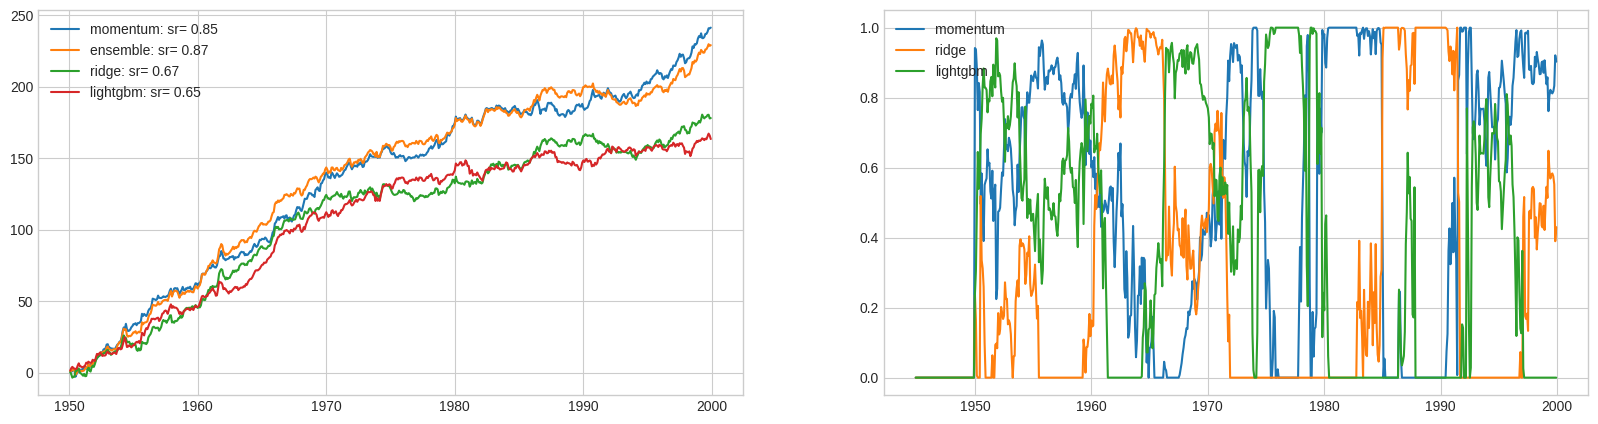

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
line(m.pnls_['1950-02-01':], cumsum=True, ax=ax[0], loc='best')
line(m.coef_, ax=ax[1], loc='best')

Over longer periods with positive constraints, the performance is closer to the industry momentum.

In [22]:
m = StackingBacktester(estimators=estimators, 
                       final_estimator=Mbj(positive=True), 
                       ret=ret, window=180,min_periods=60)

m.train(features, target)
pnls['ensemble_mbj_positive_long_window'] = m.pnls_['ensemble']

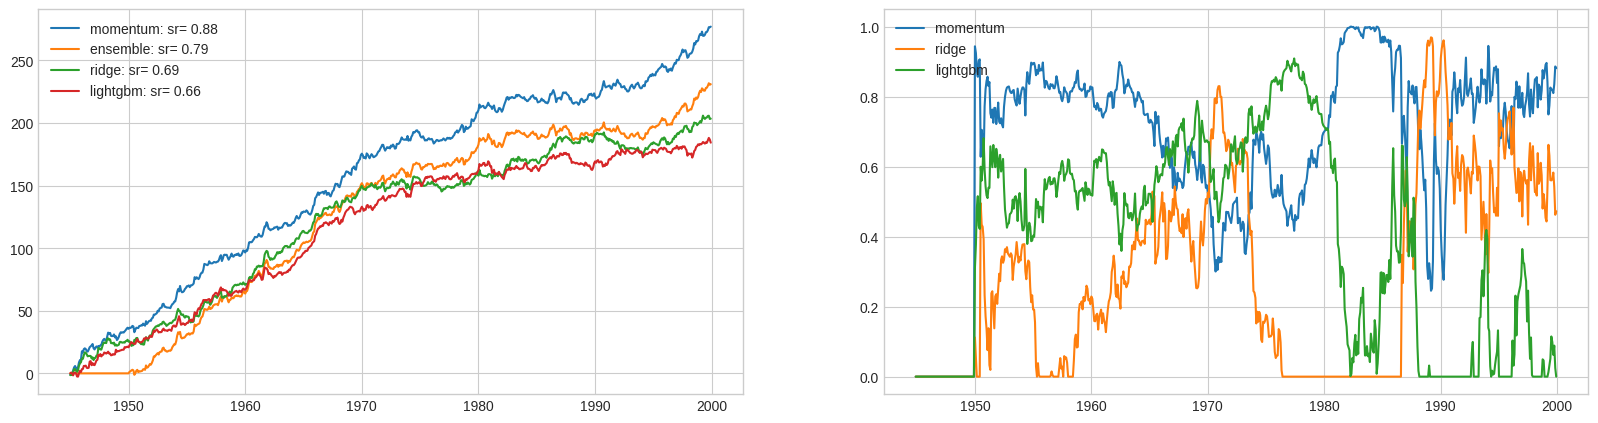

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
line(m.pnls_, cumsum=True, ax=ax[0], loc='best')
line(m.coef_, ax=ax[1], loc='best')

Putting the different ensembles, we compare the pnls in the graph below 

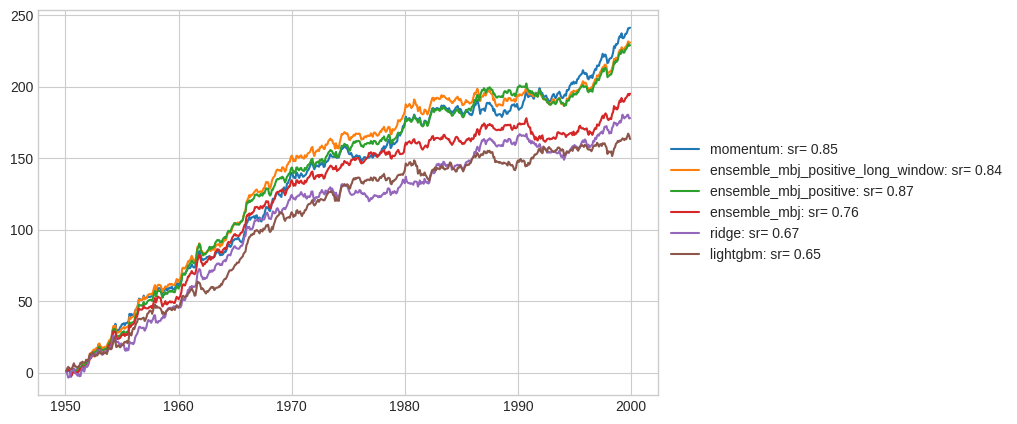

In [24]:
line(pnls['1950-02-01':], cumsum=True)